In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict
import glob
import os
import pickle
import re
import sys


sys.path.append(os.path.abspath('../../../modules'))

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import sparse
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, accuracy_score, confusion_matrix
from tqdm import tqdm_notebook

from utils.notebook_utils.dataframe_helper import load_candidate_dataframes

In [2]:
spreadsheet_names = {
    #'train': '../data/sentences/sentence_labels_train.xlsx',
    'dev': '../data/sentences/sentence_labels_dev.xlsx',
    'test': '../data/sentences/sentence_labels_test.xlsx'
}

In [3]:
candidate_dfs = {
    key:load_candidate_dataframes(spreadsheet_names[key], "curated_gig")
    for key in spreadsheet_names
}

for key in candidate_dfs:
    print("Size of {} set: {}".format(key, candidate_dfs[key].shape[0]))

Size of dev set: 500
Size of test set: 500


In [4]:
dev_baseline_df = pd.read_table("results/GiG/results/dev/baseline_marginals.tsv_dev.tsv")
dev_baseline_df.head(2)

,pos_class_marginals,neg_class_marginals,candidate_id
0,0.286556,0.309488,43397
1,0.173291,0.770575,44812


In [5]:
dev_baseline_df = dev_baseline_df.merge(candidate_dfs['dev'][["curated_gig", "candidate_id"]])
fpr, tpr, _ = roc_curve(dev_baseline_df.curated_gig, dev_baseline_df.pos_class_marginals)
precision, recall, _ = precision_recall_curve(dev_baseline_df.curated_gig, dev_baseline_df.pos_class_marginals)
dev_performance_df = pd.DataFrame([[auc(fpr, tpr), auc(recall, precision), 0]], columns=["AUROC", "AUPRC", "num_lfs"])
dev_performance_df

,AUROC,AUPRC,num_lfs
0,0.645909,0.185454,0


In [6]:
base_line = pd.read_table("results/GiG/results/dev/baseline_marginals.tsv_dev.tsv")
base_line = base_line.merge(candidate_dfs['dev'][["candidate_id", "curated_gig"]])
neg_class = sum(base_line.query("curated_gig==0").pos_class_marginals.apply(lambda x: 1 if x > 0.5 else 0).values == base_line.query("curated_gig==0").curated_gig.values)
pos_class = sum(base_line.query("curated_gig==1").pos_class_marginals.apply(lambda x: 1 if x > 0.5 else 0).values == base_line.query("curated_gig==1").curated_gig.values)

dev_baseline = pd.DataFrame([
    [neg_class/base_line.query("curated_gig==0").shape[0], 0, 0],
    [pos_class/base_line.query("curated_gig==1").shape[0], 0, 1],
], columns=["frac_correct", "num_lfs", "label"])
dev_baseline

,frac_correct,num_lfs,label
0,0.956818,0,0
1,0.083333,0,1


In [7]:
test_baseline_df = pd.read_table("results/GiG/results/test/baseline_marginals.tsv_test.tsv")
test_baseline_df.head(2)

,pos_class_marginals,neg_class_marginals,candidate_id
0,0.237355,0.741184,48486
1,0.259174,0.499493,48886


In [8]:
test_baseline_df = test_baseline_df.merge(candidate_dfs['test'][["curated_gig", "candidate_id"]])
fpr, tpr, _ = roc_curve(test_baseline_df.curated_gig, test_baseline_df.pos_class_marginals)
precision, recall, _ = precision_recall_curve(test_baseline_df.curated_gig, test_baseline_df.pos_class_marginals)
test_performance_df = pd.DataFrame([[auc(fpr, tpr), auc(recall, precision), 0]], columns=["AUROC", "AUPRC", "num_lfs"])
test_performance_df

,AUROC,AUPRC,num_lfs
0,0.615163,0.196272,0


In [9]:
base_line = pd.read_table("results/GiG/results/test/baseline_marginals.tsv_test.tsv")
base_line = base_line.merge(candidate_dfs['test'][["candidate_id", "curated_gig"]])
neg_class = sum(base_line.query("curated_gig==0").pos_class_marginals.apply(lambda x: 1 if x > 0.5 else 0).values == base_line.query("curated_gig==0").curated_gig.values)
pos_class = sum(base_line.query("curated_gig==1").pos_class_marginals.apply(lambda x: 1 if x > 0.5 else 0).values == base_line.query("curated_gig==1").curated_gig.values)

test_baseline = pd.DataFrame([
    [neg_class/base_line.query("curated_gig==0").shape[0], 0, 0],
    [pos_class/base_line.query("curated_gig==1").shape[0], 0, 1],
], columns=["frac_correct", "num_lfs", "label"])
test_baseline

,frac_correct,num_lfs,label
0,0.971698,0,0
1,0.078947,0,1


In [10]:
marginal_files = {
    "DaG":
    {
        "dev": "results/DaG/results/dev/",
        "test": "results/DaG/results/test/",
        "endpoint": 30
    },
    "CtD":
    {
        "dev": "results/CtD/results/dev/",
        "test": "results/CtD/results/test/",
        "endpoint": 22
    },
    "CbG":
    {
        "dev": "results/CbG/results/dev/",
        "test": "results/CbG/results/test/",
        "endpoint": 20
    },
    "GiG":
    {
        "dev": "results/GiG/results/dev/",
        "test": "results/GiG/results/test/",
        "endpoint": 28
    },
    "All":
    {
        "dev": "results/all/results/dev/",
        "test": "results/all/results/test/",
        "endpoint": 100
    }
}

In [11]:
starting_point = 0
step = 5
num_of_points = 4

lf_ranges = {
    "DaG": [starting_point] + [1 + step*index for index in range(num_of_points)] + [30],
    "CtD": [starting_point] + [1 + step*index for index in range(num_of_points)] + [22],
    "CbG": [starting_point] + [1 + step*index for index in range(num_of_points)] + [20],
    "GiG": [starting_point] + [1 + step*index for index in range(num_of_points)] + [28],
    "All": [starting_point] + [1 + 32*index for index in range(num_of_points)] + [100],
}

In [12]:
def get_disc_performance(
    result_files, performance_df, baseline, lf_ranges,
    data_set_category="dev", curated_field="curated_gig",
):
    
    performance_dict = {}
    class_performance_dict = {}
    
    for category in result_files:
        performance_data = []
        class_data = []

        
        for marginal_data in glob.glob(marginal_files[category][data_set_category]+"[0-9]*.tsv"):
            num_lfs = int(re.search(r"([\d]+)", marginal_data).group(0))
            
            # skip file if not in range
            if num_lfs not in lf_ranges[category]:
                continue
                
            data = pd.read_table(marginal_data).sort_values("candidate_id").drop_duplicates()
            neg_correct = 0
            pos_correct = 0
            new_data = (
                data.merge(
                    candidate_dfs[data_set_category][["candidate_id", curated_field]]
                    .astype({curated_field:int}),
                    how="inner",
                    on="candidate_id"
                    
                )
            )
            total_sampled = len([col for col in data.columns if col != "candidate_id"])
            for col in [col for col in data.columns if col != "candidate_id"]:
                fpr, tpr, _ = roc_curve(new_data[curated_field], new_data[col])
                precision, recall, _ = precision_recall_curve(new_data[curated_field], new_data[col])
                performance_data.append([auc(fpr, tpr), auc(recall, precision), num_lfs])

                # change marginals into predicted values
                # add actual values
                # calculate the number of correct predictions
                neg_correct += sum(
                    new_data
                    [new_data[curated_field]==0]
                    [col]
                    .apply(lambda x: 1 if x > 0.5 else 0)
                    .values
                    == 
                    new_data
                    [new_data[curated_field]==0]
                    [curated_field]
                    .values
                )
                pos_correct += sum(
                    new_data
                    [new_data[curated_field]==1]
                    [col]
                    .apply(lambda x: 1 if x > 0.5 else 0)
                    .values
                    == 
                    new_data
                    [new_data[curated_field]==1]
                    [curated_field]
                    .values
                ) 
        
            class_data.append({
                "frac_correct":neg_correct / (new_data[new_data[curated_field]==0].shape[0]*total_sampled),
                "num_lfs": num_lfs,
                "label": 0
            })
            
            class_data.append({
                "frac_correct":pos_correct / (new_data[new_data[curated_field]==1].shape[0]*total_sampled),
                "num_lfs": num_lfs,
                "label": 1
            })
        
        if len(class_data) == 0:
            continue
            
        class_performance_df = (
            pd.DataFrame.from_records(class_data)
            .sort_values("num_lfs")
        )
        
        class_performance_dict[category] = baseline.append(class_performance_df, sort=False)
        
        temp_performance_df = (
            performance_df
            .append(
                pd.DataFrame(performance_data, columns=["AUROC", "AUPRC", "num_lfs"]),
                sort=True
            )
        )
        performance_dict[category] = temp_performance_df
    return performance_dict, class_performance_dict

In [13]:
dev_performance_dict, dev_class_performance_dict  = get_disc_performance(
    marginal_files, dev_performance_df, dev_baseline, lf_ranges,
    data_set_category="dev", curated_field="curated_gig"
)

test_performance_dict, test_class_performance_dict = get_disc_performance(
    marginal_files, test_performance_df, test_baseline, lf_ranges,
    data_set_category="test", curated_field="curated_gig"
)

In [14]:
gen_model_files = {
    "dev": {
        "DaG":"results/DaG/results/dev_sampled_performance.tsv",
        "GiG":"results/GiG/results/dev_sampled_performance.tsv",
        "CbG":"results/CbG/results/dev_sampled_performance.tsv",
        "CtD":"results/CtD/results/dev_sampled_performance.tsv",
        "All":"results/all/results/dev_sampled_performance.tsv"
    },
    "test":{
        "DaG":"results/DaG/results/test_sampled_performance.tsv",
        "GiG":"results/GiG/results/test_sampled_performance.tsv",
        "CbG":"results/CbG/results/test_sampled_performance.tsv",
        "CtD":"results/CtD/results/test_sampled_performance.tsv",
        "All":"results/all/results/test_sampled_performance.tsv"
    }
}

In [15]:
def get_gen_performance(model_files, performance_dict):
    for category in model_files:
        gen_model_performance_df = pd.read_table(model_files[category]).assign(label="gen_model")
        if category in performance_dict:
            performance_dict[category] = (
                performance_dict[category]
                .assign(label="disc_model")
                .append(gen_model_performance_df.drop("l2_param", axis=1))
                .query("num_lfs in @lf_ranges[@category]", engine="python")
            )
    return performance_dict

In [16]:
dev_performance_dict = get_gen_performance(gen_model_files["dev"], dev_performance_dict)
test_performance_dict = get_gen_performance(gen_model_files["test"], test_performance_dict)

# Gene interacts Gene Sources

## Dev Set

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


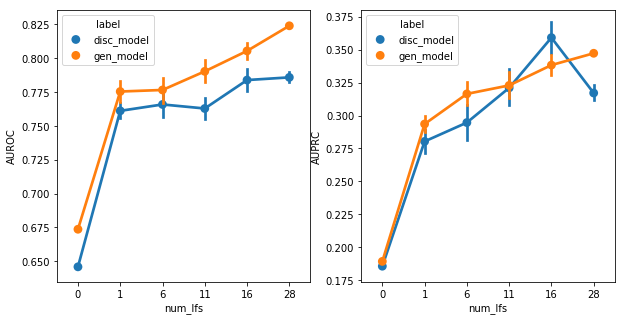

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUROC", hue="label", data=dev_performance_dict["GiG"], ax=axs[0])
sns.pointplot(x="num_lfs", y="AUPRC", hue="label", data=dev_performance_dict["GiG"], ax=axs[1])

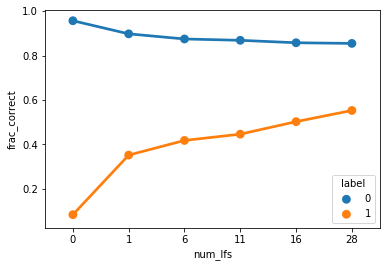

In [18]:
sns.pointplot(x="num_lfs", y="frac_correct", hue="label", data=dev_class_performance_dict["GiG"])

## Test Set

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


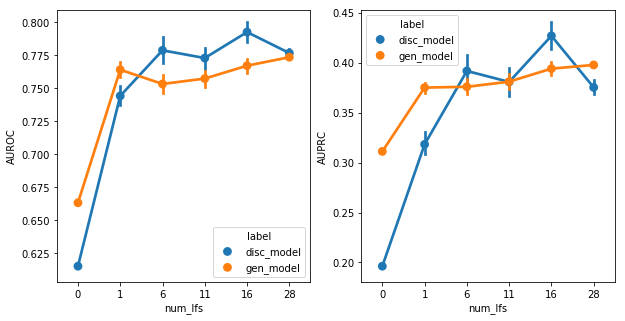

In [19]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUROC", hue="label", data=test_performance_dict["GiG"], ax=axs[0])
sns.pointplot(x="num_lfs", y="AUPRC", hue="label", data=test_performance_dict["GiG"], ax=axs[1])

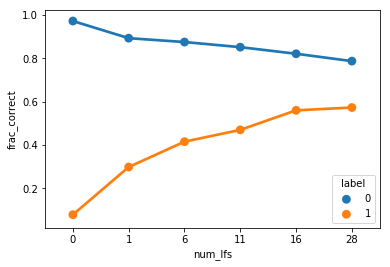

In [20]:
sns.pointplot(x="num_lfs", y="frac_correct", hue="label", data=test_class_performance_dict["GiG"])

In [21]:
dev_performance_dict["GiG"].to_csv(
    "results/GiG/results/dev_disc_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_performance_dict["GiG"].to_csv(
    "results/GiG/results/test_disc_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

In [22]:
dev_class_performance_dict["GiG"].to_csv(
    "results/GiG/results/dev_disc_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_class_performance_dict["GiG"].to_csv(
    "results/GiG/results/test_disc_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

# Compound Binds Gene Sources

## Dev Set

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


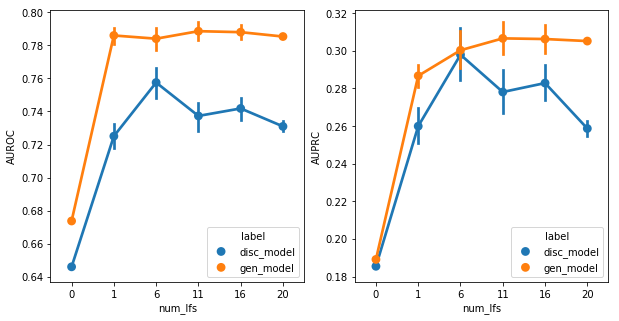

In [23]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUROC", hue="label", data=dev_performance_dict["CbG"], ax=axs[0])
sns.pointplot(x="num_lfs", y="AUPRC", hue="label", data=dev_performance_dict["CbG"], ax=axs[1])

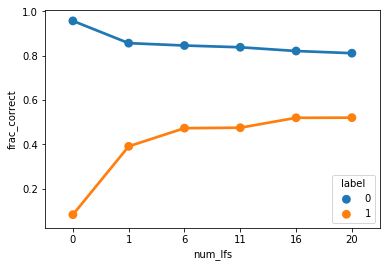

In [24]:
sns.pointplot(x="num_lfs", y="frac_correct", hue="label", data=dev_class_performance_dict["CbG"])

## Test Set

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


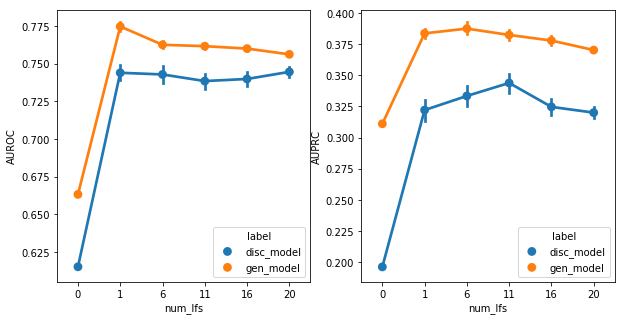

In [25]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUROC", hue="label", data=test_performance_dict["CbG"], ax=axs[0])
sns.pointplot(x="num_lfs", y="AUPRC", hue="label", data=test_performance_dict["CbG"], ax=axs[1])

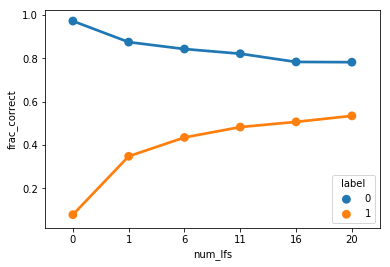

In [26]:
sns.pointplot(x="num_lfs", y="frac_correct", hue="label", data=test_class_performance_dict["CbG"])

In [27]:
dev_performance_dict["CbG"].to_csv(
    "results/CbG/results/dev_disc_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_performance_dict["CbG"].to_csv(
    "results/CbG/results/test_disc_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

In [28]:
dev_class_performance_dict["CbG"].to_csv(
    "results/CbG/results/dev_disc_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_class_performance_dict["CbG"].to_csv(
    "results/CbG/results/test_disc_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

# Disease Associates Gene Sources 

## Dev Set

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


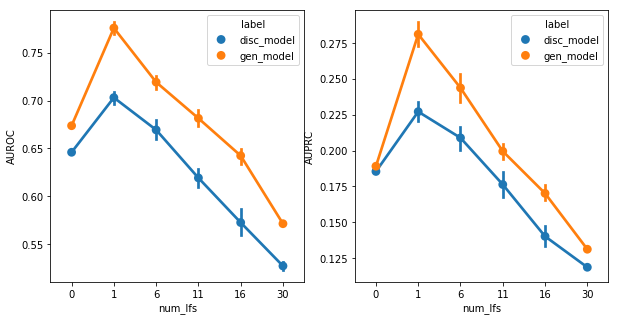

In [29]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUROC", hue="label", data=dev_performance_dict["DaG"], ax=axs[0])
sns.pointplot(x="num_lfs", y="AUPRC", hue="label", data=dev_performance_dict["DaG"], ax=axs[1])

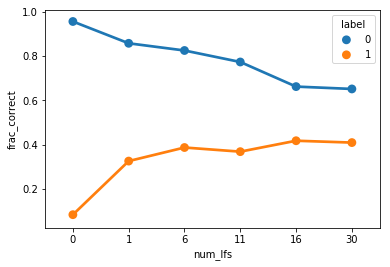

In [30]:
sns.pointplot(x="num_lfs", y="frac_correct", hue="label", data=dev_class_performance_dict["DaG"])

## Test Set

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


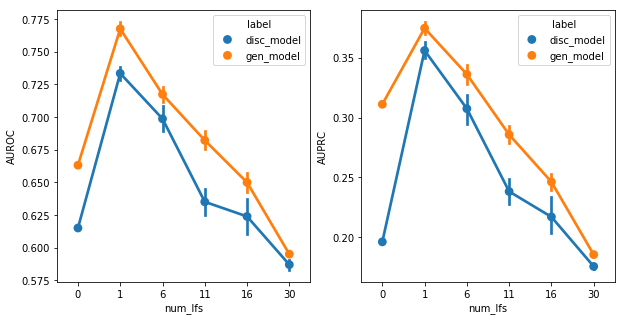

In [31]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUROC", hue="label", data=test_performance_dict["DaG"], ax=axs[0])
sns.pointplot(x="num_lfs", y="AUPRC", hue="label", data=test_performance_dict["DaG"], ax=axs[1])

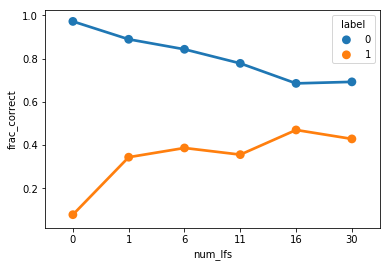

In [32]:
sns.pointplot(x="num_lfs", y="frac_correct", hue="label", data=test_class_performance_dict["DaG"])

In [33]:
dev_performance_dict["DaG"].to_csv(
    "results/DaG/results/dev_disc_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_performance_dict["DaG"].to_csv(
    "results/DaG/results/test_disc_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

In [34]:
dev_class_performance_dict["DaG"].to_csv(
    "results/DaG/results/dev_disc_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_class_performance_dict["DaG"].to_csv(
    "results/DaG/results/test_disc_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

# Compound Treats Disease Sources

## Dev Set

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


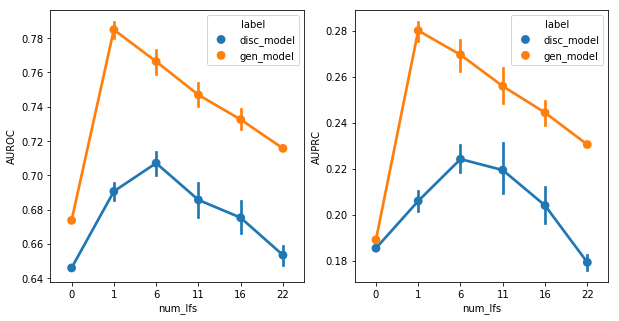

In [35]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUROC", hue="label", data=dev_performance_dict["CtD"], ax=axs[0])
sns.pointplot(x="num_lfs", y="AUPRC", hue="label", data=dev_performance_dict["CtD"], ax=axs[1])

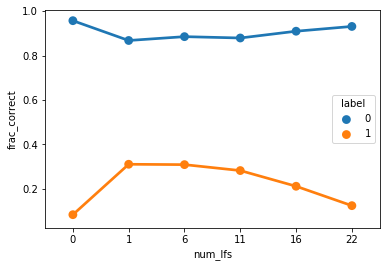

In [36]:
sns.pointplot(x="num_lfs", y="frac_correct", hue="label", data=dev_class_performance_dict["CtD"])

## Test Set

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


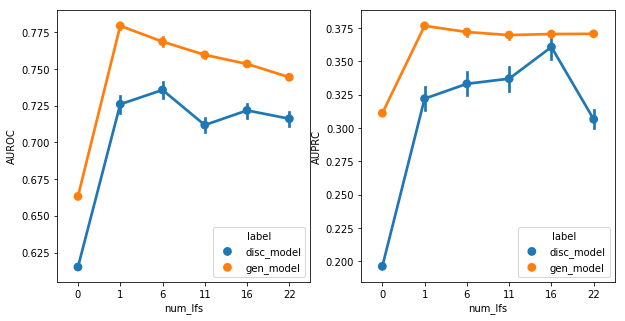

In [37]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUROC", hue="label", data=test_performance_dict["CtD"], ax=axs[0])
sns.pointplot(x="num_lfs", y="AUPRC", hue="label", data=test_performance_dict["CtD"], ax=axs[1])

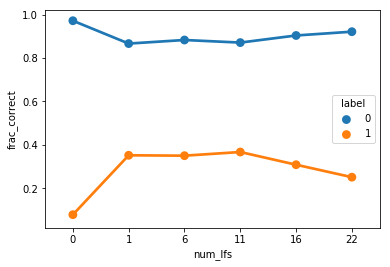

In [38]:
sns.pointplot(x="num_lfs", y="frac_correct", hue="label", data=test_class_performance_dict["CtD"])

In [39]:
dev_performance_dict["CtD"].to_csv(
    "results/CtD/results/dev_disc_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_performance_dict["CtD"].to_csv(
    "results/CtD/results/test_disc_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

In [40]:
dev_class_performance_dict["CtD"].to_csv(
    "results/CtD/results/dev_disc_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_class_performance_dict["CtD"].to_csv(
    "results/CtD/results/test_disc_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

# All

## Dev Set

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


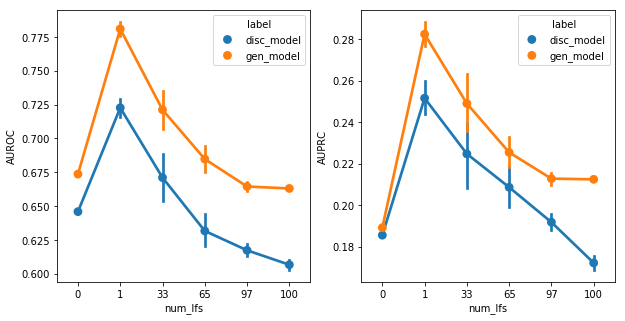

In [41]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUROC", hue="label", data=dev_performance_dict["All"], ax=axs[0])
sns.pointplot(x="num_lfs", y="AUPRC", hue="label", data=dev_performance_dict["All"], ax=axs[1])

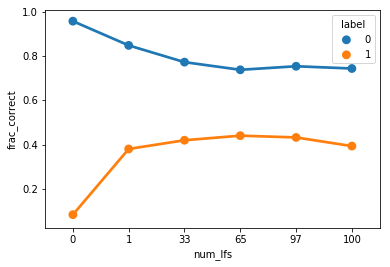

In [42]:
sns.pointplot(x="num_lfs", y="frac_correct", hue="label", data=dev_class_performance_dict["All"])

## Test Set

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


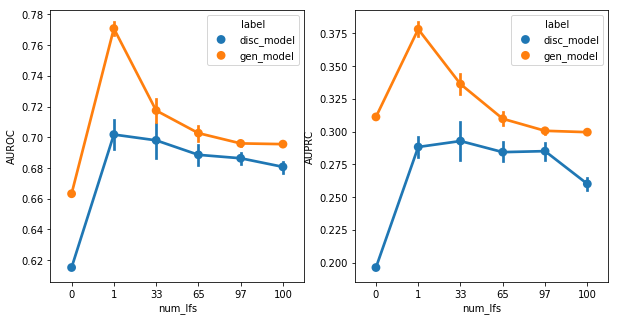

In [43]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUROC", hue="label", data=test_performance_dict["All"], ax=axs[0])
sns.pointplot(x="num_lfs", y="AUPRC", hue="label", data=test_performance_dict["All"], ax=axs[1])

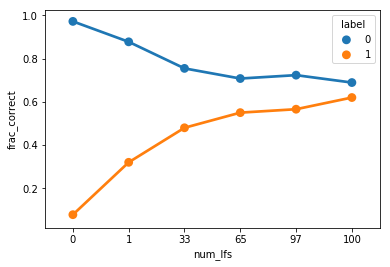

In [44]:
sns.pointplot(x="num_lfs", y="frac_correct", hue="label", data=test_class_performance_dict["All"])

In [45]:
dev_performance_dict["All"].to_csv(
    "results/all/results/dev_disc_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_performance_dict["All"].to_csv(
    "results/all/results/test_disc_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

In [46]:
dev_class_performance_dict["GiG"].to_csv(
    "results/all/results/dev_disc_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_class_performance_dict["GiG"].to_csv(
    "results/all/results/test_disc_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)